In [2]:
import re
import json
import os

def preprocess(text):
    punctuations = "，。！？；：“”（）"
    input_text = ""
    punctuation_indices = []
    punctuation_types = []

    for idx, char in enumerate(text):
        if char in punctuations:
            punctuation_indices.append(len(input_text))
            punctuation_types.append(char)
        else:
            input_text += char

    return input_text, punctuation_indices, punctuation_types


In [ ]:
def process_folder(folder_path, output_file):
    data_points = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for i, line in enumerate(lines):
                    line = line.strip()
                    if not line:
                        continue  # jump empty lines
                    input_text, indices, types = preprocess(line)
                    data_point = {
                        "filename": filename,
                        "line_number": i + 1,
                        "input_text": input_text,
                        "punctuation_indices": indices,
                        "punctuation_types": types
                    }
                    data_points.append(data_point)

    with open(output_file, 'w', encoding='utf-8') as out_f:
        for dp in data_points:
            out_f.write(json.dumps(dp, ensure_ascii=False) + "\n")

    print(f"Have processed {len(data_points)} data points，output file：{output_file}")

In [ ]:
if __name__ == "__main__":
    folder_path = "Corpus/十國春秋_cleaned"
    output_file = "processed_data_sgcq2.jsonl"
    process_folder(folder_path, output_file)

✅ 共处理了 6581 条 data points，输出文件：processed_data_sgcq2.jsonl


In [ ]:
import json
from tqdm import tqdm

# Punctuation mapping to numeric labels
punctuation_map = {
    "，": 1,
    "。": 2,
    # "？": 3,
    # "！": 4,
    # "；": 5,
    "：": 3,
    # "“": 7,
    # "”": 7,
    # "‘": 8,
    # "’": 8,
    # "（": 9,
    # "）": 9
}

# Build character-level inputs and labels
def build_dataset(jsonl_path, vocab=None):
    all_X = []
    all_y = []
    char2idx = {} if vocab is None else vocab
    idx = 1  # Reserve 0 for padding

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing"):
            data = json.loads(line)
            input_text = data["input_text"]
            punct_indices = data["punctuation_indices"]
            punct_types = data["punctuation_types"]

            # Encode input_text as a sequence of character IDs
            X = []
            for ch in input_text:
                if vocab is None:
                    if ch not in char2idx:
                        char2idx[ch] = idx
                        idx += 1
                X.append(char2idx.get(ch, 0))   # 0 for unknown character

            #  Construct label sequence aligned with characters
            y = [0] * len(input_text)
            for i, punct in zip(punct_indices, punct_types):
                if i < len(y):
                    y[i] = punctuation_map.get(punct, 0) # Unknown punctuation as 0 (i.e., no punctuation)

            all_X.append(X)
            all_y.append(y)

    return all_X, all_y, char2idx

X, y, char2idx = build_dataset("processed_data_sgcq2.jsonl")

with open("char2idx_2.json", "w", encoding="utf-8") as f:
    json.dump(char2idx, f, ensure_ascii=False)



Processing: 6581it [00:00, 126852.46it/s]


In [6]:
jsonl_file = "processed_data_sgcq2.jsonl"
X, y, vocab = build_dataset(jsonl_file)

print("numbers of sample：", len(X))
print("first input sequence（char ID）:", X[0])
print("first label sequence：", y[0])
print("numbers of char：", len(vocab))


Processing: 6581it [00:00, 100612.78it/s]

numbers of sample： 6581
first input sequence（char ID）: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 7, 9, 20]
first label sequence： [0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]
numbers of char： 5141


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM,
    Dense, TimeDistributed, Dropout, Add, LayerNormalization, MultiHeadAttention
)

def build_enhanced_punctuation_model(vocab_size,
                                      num_classes,
                                      embedding_dim=128,
                                      lstm_units=128,
                                      num_heads=4,
                                      dropout_rate=0.2):
    input_seq = Input(shape=(None,), dtype='int32')  # [batch_size, seq_len]

    # Embedding layer + Mask 
    x = Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True)(input_seq)

    # first layer BiLSTM
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate))(x)

    # second layer BiLSTM
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate))(x)

    # Multi-Head Attention layer
    attn_output = MultiHeadAttention(num_heads=num_heads,
                                     key_dim=embedding_dim)(x, x)

    # Residual connection + LayerNorm
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    # TimeDistributed output for punctuation class prediction
    output = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

    model = Model(inputs=input_seq, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True)

    return model


X, y, char2idx = build_dataset("processed_data_sgcq2.jsonl")
max_len = max(len(seq) for seq in X)
X_pad = pad_sequences(X, maxlen=max_len, padding='post')
y_pad = pad_sequences(y, maxlen=max_len, padding='post')
y_pad = np.expand_dims(y_pad, -1)

Processing: 6581it [00:00, 130327.51it/s]


In [10]:
model_enhanced = build_enhanced_punctuation_model(
    vocab_size=len(char2idx),
    num_classes=10,
    embedding_dim=128,
    lstm_units=128,
    num_heads=4,
    dropout_rate=0.3
)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model_enhanced.fit(X_pad, y_pad, batch_size=32, epochs=20, validation_split=0.1)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 178s 958ms/step - accuracy: 0.9226 - loss: 0.2947 - val_accuracy: 0.9304 - val_loss: 0.2071
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 178s 954ms/step - accuracy: 0.9296 - loss: 0.2061 - val_accuracy: 0.9390 - val_loss: 0.1747
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 954ms/step - accuracy: 0.9381 - loss: 0.1721 - val_accuracy: 0.9427 - val_loss: 0.1573
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 173s 930ms/step - accuracy: 0.9435 - loss: 0.1525 - val_accuracy: 0.9444 - val_loss: 0.1556
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 178s 958ms/step - accuracy: 0.9481 - loss: 0.1394 - val_accuracy: 0.9451 - val_loss: 0.1601
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 172s 922ms/step - accuracy: 0.9511 - loss: 0.1302 - val_accuracy: 0.9453 - val_loss: 0.1634
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 179s 961ms/step - accuracy: 0.9545 - loss: 0.1226 - val_accuracy: 0.9444 - val_loss: 0.1615
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.9567 -

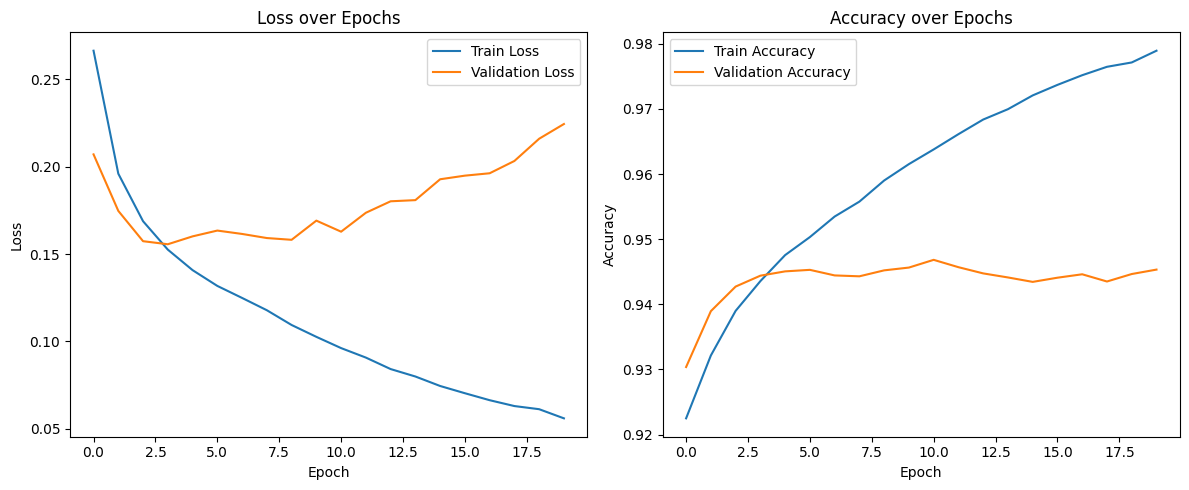

In [ ]:
import matplotlib.pyplot as plt

# plot Loss curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


206/206 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step


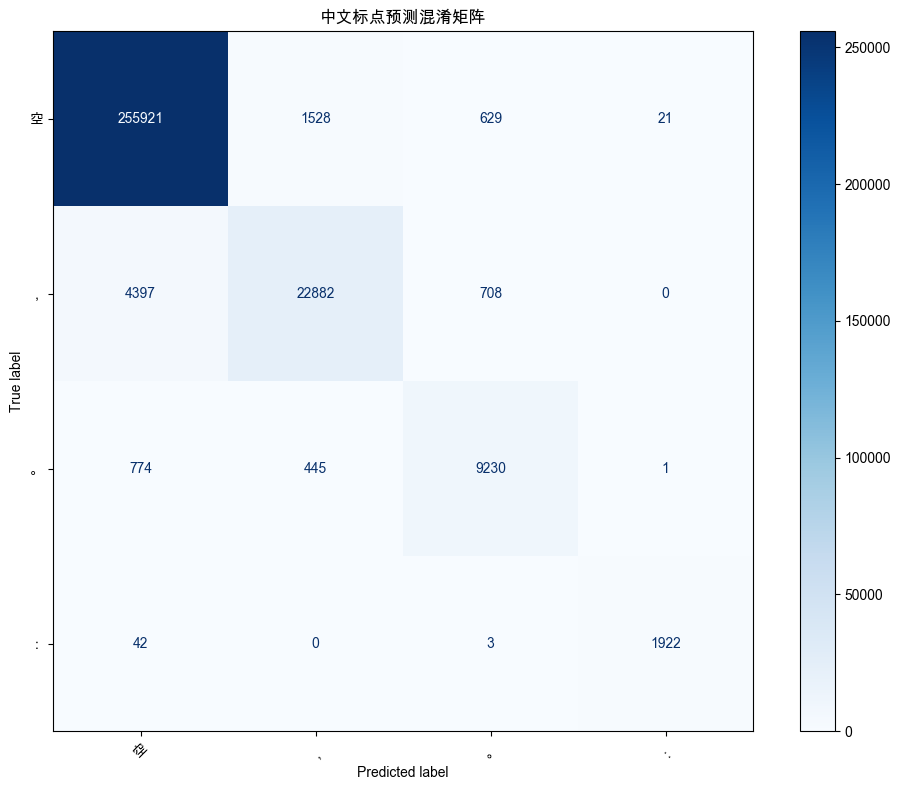


分类报告（Precision / Recall / F1-Score）：

              precision    recall  f1-score   support

           空     0.9800    0.9916    0.9858    258099
           ，     0.9206    0.8176    0.8661     27987
           。     0.8732    0.8833    0.8782     10450
           ：     0.9887    0.9771    0.9829      1967

    accuracy                         0.9714    298503
   macro avg     0.9406    0.9174    0.9282    298503
weighted avg     0.9708    0.9714    0.9708    298503


Total Accuracy: 0.9714


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Set Chinese font for display (adjust based on your system)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 也可换成 SimHei、Noto Sans CJK SC
plt.rcParams['axes.unicode_minus'] = False

# Punctuation label mapping 
punctuation_map = {
    "，": 1,
    "。": 2,
    # "？": 3,
    # "！": 4,
    # "；": 5,
    "：": 3,
    # "“": 7,
    # "”": 7,
    # "‘": 8,
    # "’": 8,
    # "（": 9,
    # "）": 9
}
idx2punct = {v: k for k, v in punctuation_map.items()}
idx2punct[0] = "空"

# Model prediction
#y_pred_prob = model.predict(X_pad)
y_pred_prob = model_enhanced.predict(X_pad)
y_pred = np.argmax(y_pred_prob, axis=-1)

# Flatten and ignore padding
y_true_flat = []
y_pred_flat = []

for i in range(len(y_pad)):
    for j in range(len(y_pad[i])):
        if X_pad[i][j] != 0:
            y_true_flat.append(y_pad[i][j][0])
            y_pred_flat.append(y_pred[i][j])

# Label types and names
labels = sorted(set(y_true_flat + y_pred_flat))
display_labels = [idx2punct.get(i, str(i)) for i in labels]

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)

# Set font for axes
for label in ax.get_xticklabels():
    label.set_fontname("Arial Unicode MS")
for label in ax.get_yticklabels():
    label.set_fontname("Arial Unicode MS")

plt.title("Confusion Matrix for Chinese Punctuation Prediction", fontname="Arial Unicode MS")
plt.tight_layout()
plt.show()

# Print F1-score and other metrics
target_names = display_labels
print("\nClassification Report (Precision / Recall / F1-Score)：\n")
print(classification_report(y_true_flat, y_pred_flat, labels=labels, target_names=target_names, digits=4))

# Accuracy
acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"\nTotal Accuracy: {acc:.4f}")


In [15]:
model_enhanced.save("model_attention.h5")

with open("char2idx_2.json", "r", encoding="utf-8") as f:
    char2idx = json.load(f)


In [ ]:
# Punctuation ID to character mapping
punctuation_id2char = {0: "", 1: "，", 2: "。", 
                    #    3: "？", 4: "！", 5: "；", 
                       3: "：", 
                    #    7: "”", 8: "’", 9: "）"
                    }

# use this function for inference
def resolve_punctuation(label_id):
    if label_id not in [7, 8, 9]:
        # Direct mapping for asymmetric punctuation
        return {
            1: "，", 2: "。", 
            # 3: "？", 4: "！", 5: "；", 
            3: "："
        }.get(label_id, "")
    

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_punctuation(text, model, char2idx, punctuation_id2char, max_len=200):
    chars = list(text)
    input_ids = [char2idx.get(ch, 0) for ch in chars]
    input_ids = pad_sequences([input_ids], maxlen=max_len, padding='post')

    preds = model.predict(input_ids)[0]  # shape: (seq_len, num_classes)
    pred_classes = np.argmax(preds, axis=-1)

    # Restore text with predicted punctuation
    result = ""
    for i, ch in enumerate(chars):
        result += ch
        label = pred_classes[i]
        if label != 0:  # Add punctuation if needed
            result += resolve_punctuation(label)

    return result


In [20]:
test_text = "先帝創業未半而中道崩殂今天下三分益州疲弊"
output_text = predict_punctuation(test_text, model_enhanced, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
原文（无标点）: 先帝創業未半而中道崩殂今天下三分益州疲弊
预测（加标点）: 先帝創業未半而，中道崩殂今。天下三分益，州疲弊


In [21]:
test_text = "親賢臣遠小人此先漢所以興隆也親小人遠賢臣此後漢所以傾頹也"
output_text = predict_punctuation(test_text, model_enhanced, char2idx, punctuation_id2char)
print("原文（无标点）:", test_text)
print("预测（加标点）:", output_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
原文（无标点）: 親賢臣遠小人此先漢所以興隆也親小人遠賢臣此後漢所以傾頹也
预测（加标点）: 親賢臣遠小人此。先漢所以興隆也親。小人遠賢臣此後漢所以傾頹也
